In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
import re
import pyspark.sql.functions as f
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import NGram
from pyspark.ml.feature import MaxAbsScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.clustering import BisectingKMeans

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Jeopardy Calculation") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

from nltk.stem.porter import *
stemmer = PorterStemmer()
def stem(in_vec):
    out_vec = []
    for t in in_vec:
        t_stem = stemmer.stem(t)
        out_vec.append(t_stem)       
    return out_vec
from pyspark.sql.types import *
stemmer_udf = udf(lambda x: stem(x), ArrayType(StringType()))

In [2]:
#reading in the jeopardy data set
jeopardy = spark.read.json("JEOPARDY_QUESTIONS1-Copy1.json")
j_categoryCount = jeopardy.groupBy("category").count()
#This is the number of categories in the dataset which have greater than 100 observations
count100 = j_categoryCount.sort(desc("count")).filter(j_categoryCount["count"] > 100).count()
#This is a list of all categories which have a count greater than 100
top_categories = list(j_categoryCount.sort(desc("count")).select("category").limit(count100).toPandas().category)
#new dataset that only contains categories that have greater than 100 osbervations
jeo_f = jeopardy.where(col("category").isin(top_categories))

In [3]:
#stripping punctuation, tokenizing, stop word removing, and stemming for the modified dataset
jeo_fpunc = jeo_f.withColumn("stripped", f.regexp_replace(f.col("question"), "[\!@#$%^&*)(><,';:]", ""))
jeo_fpunc.cache()
tokenizer = Tokenizer(inputCol = "stripped", outputCol = "words")
tokenized_f = tokenizer.transform(jeo_fpunc)
tokenized_f.cache()
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
jeo_fStopRemoved = remover.transform(tokenized_f)
jeo_fStopRemoved.cache()
jeo_fStemmed = jeo_fStopRemoved.withColumn("stemmed", stemmer_udf("filtered"))
jeo_fStemmed.cache()


DataFrame[air_date: string, answer: string, category: string, question: string, round: string, show_number: string, value: string, stripped: string, words: array<string>, filtered: array<string>, stemmed: array<string>]

# Logistic Regression on Human Defined Clusters

In [4]:
humanclust = [9, 0, 5, 7, 9, 7, 9, 2, 7, 8, 2, 2, 3, 1, 2, 8, 3, 2, 2, 5, 6, 5, 5, 8, 8, 5, 9, 4, 0, 6,
              9, 5, 6, 5, 7, 1, 8, 0, 7, 9, 2, 8, 9, 8, 5, 6, 4, 6, 5, 9, 9, 5, 5, 8, 2, 6, 2, 7, 6, 4,
              4, 0, 1, 9, 7, 0, 2, 1, 9, 7, 0, 4, 4, 4, 0, 0, 4, 2, 1, 0, 8, 9, 4, 8, 0, 1, 9, 9, 8, 8,
              9, 0, 7, 0, 7, 4, 2, 9, 4, 4, 0, 7, 9, 0, 4, 4, 3, 2, 1, 9, 8, 4, 4, 9, 5, 9, 1, 0, 2, 4,
              1, 9, 4, 4, 9, 6, 4, 4, 5, 4, 8, 9, 6, 5, 5, 0, 2, 0, 0, 4, 8, 8, 4, 7, 2]
human_udf = udf(lambda x: int(humanclust[top_categories.index(x)]))
jeo_g = jeo_fStemmed.withColumn("human", human_udf(jeo_f.category).cast("integer"))


In [5]:
training,test = jeo_g.randomSplit([0.8,0.2], seed = 1) 

In [19]:
hashingTF = HashingTF(inputCol="stemmed", outputCol="rawFeatures", numFeatures = 50000)
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
indexer = StringIndexer(inputCol="human", outputCol="label")
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, elasticNetParam=0.8,
                       family="multinomial")

pipelineLR = Pipeline(stages=[hashingTF,idf,indexer,lr])
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.001,0.0025,0.005,0.0075,.01]) \
    .build()

crossval = CrossValidator(estimator=pipelineLR,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)
cvModel = crossval.fit(training)

In [20]:
prediction = cvModel.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.5044232732221844


In [21]:
cvModel.avgMetrics

[0.4624088372363486,
 0.48117086297810086,
 0.49684745917594786,
 0.49839143565237204,
 0.4908468277268364]

In [22]:
prediction.groupBy('prediction').count().sort(desc("prediction")).show(145)

+----------+-----+
|prediction|count|
+----------+-----+
|       9.0|  159|
|       8.0|  222|
|       7.0|  240|
|       6.0|  374|
|       5.0|  503|
|       4.0|  546|
|       3.0|  698|
|       2.0|  834|
|       1.0|  628|
|       0.0| 1674|
+----------+-----+



# Word Clouds for Logistic Regression Predictions

In [23]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as mp

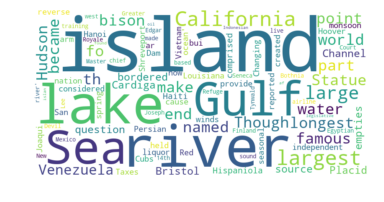

In [27]:
text = prediction.filter(prediction["prediction"] == 9).select("question").toPandas()
questions = str(text)
wordcloud = WordCloud(max_words=100, width=800, height=400, background_color="white").generate(questions)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
#wordcloud.to_file("LR_Human_images/watergeographyLRH.png")

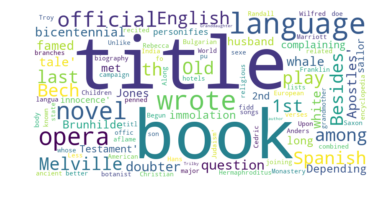

In [29]:
text = prediction.filter(prediction["prediction"] == 3).select("question").toPandas()
questions = str(text)
wordcloud = WordCloud(max_words=100, width=800, height=400, background_color="white").generate(questions)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
#wordcloud.to_file("LR_Human_images/literatureLRH.png")

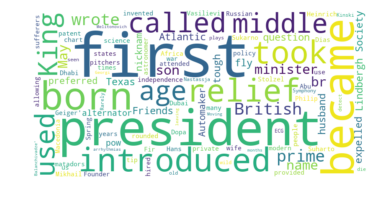

In [32]:
text = prediction.filter(prediction["prediction"] == 1).select("question").toPandas()
questions = str(text)
wordcloud = WordCloud(max_words=100, width=800, height=400, background_color="white").generate(questions)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
#wordcloud.to_file("LR_Human_images/peopleLRH.png")

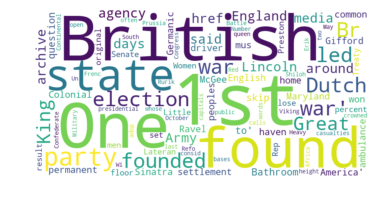

In [34]:
text = prediction.filter(prediction["prediction"] == 6).select("question").toPandas()
questions = str(text)
wordcloud = WordCloud(max_words=100, width=800, height=400, background_color="white").generate(questions)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
#wordcloud.to_file("LR_Human_images/historyLRH.png")